# Rate Function Plots

In this notebook we plot FTLE rate function convergence plots

In [1]:
# Standard Imports

import numpy as np
import xarray as xr
import sys
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm 

In [2]:
from ginelli_plot import *

### Reading Experiment Data

In [5]:
directory = '../Data'
h_experiment=[]
for i in tqdm(range(1, 6)):
    ds = xr.open_mfdataset(directory + f'/{i}/step5/*.nc', parallel=True, combine='by_coords', concat_dim='time')
    h_experiment.append(ds)

In [39]:
for experiment in [h_experiment]:
    kds = []
    for data in tqdm(experiment):
        CLE = spectra(data)
        kd = min_pos(CLE)
        kds.append(kd)

    # Append to experiment
    for i, data in enumerate(experiment):
        print(f'h={data.h}, append kd ={kds[i]}\n')
        data.attrs.update({'k_d': kds[i]})


h=0.0625, append kd =164

h=0.296875, append kd =168

h=0.53125, append kd =180

h=0.765625, append kd =199

h=1.0, append kd =218



# Rate Function Calculation

In [13]:
def ftcle_calculator(cle, L):
    return cle.rolling(time = L).mean()[L - 1::L]

<xarray.DataArray (time: 1500, le_index: 396)>
dask.array<getitem, shape=(1500, 396), dtype=float64, chunksize=(50, 396), chunktype=numpy.ndarray>
Coordinates:
  * le_index  (le_index) int32 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396
  * time      (time) float64 51.1 51.2 51.3 51.4 ... 200.7 200.8 200.9 201.0

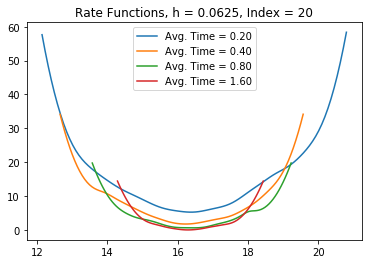

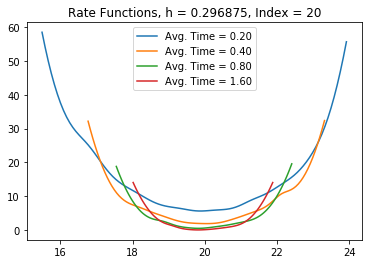

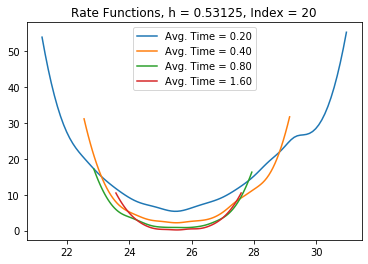

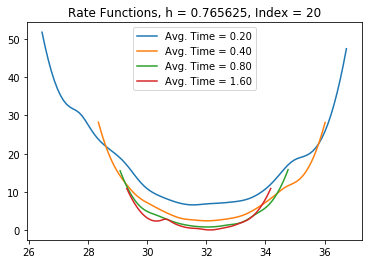

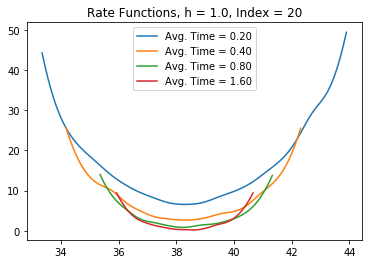

In [37]:
Ls = [80, 160, 320, 640]
for i, data in enumerate(h_experiment):
    
    # Info we need from the data
    tau = data.tau
    h = data.h
    kd = data.k_d
    
    print(f'Working on plots for h = {h:.2f}\n')
    
    # Save Directory
    dirName = f'h-effect/{i + 1}/Rate-Functions_h{h:.2f}'.replace('.','_')
#     if not os.path.exists(dirName):
#         os.mkdir(dirName)
#         print("Directory " , dirName ,  " Created ")
#     else:    
#         print("Directory " , dirName ,  " already exists")
    
    # Looping of the LE_ indexes we want
    indexes = [1, 2, 3, kd - 2, kd - 1, kd, kd + 1, kd + 2, 394, 395, 396]
    for index in tqdm(indexes):
        save = dirName + f'/LE_Index_{index}.png'
        print(f'Will save at {save}')
        
    # Loop for different averaging times
        for L in Ls:
            Ltau = L * tau
            ftle = ftcle_calculator(data.ftcle, L)
            FTLE = ftle.sel(le_index = index)
            x_d = np.linspace(FTLE.min() - 1, FTLE.max() + 1, 100) # Grid we evaluate PDF on
            kde = gaussian_kde(FTLE) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
            pdf = kde.evaluate(x_d)
            rate = - (np.log(pdf) / Ltau)
            plt.plot(x_d, rate, label = f'Avg. Time = {Ltau:.2f}')
        plt.title(f'Rate Function, h = {data.h:.2f}, LE Index = {index}')
        plt.xlim(FTLE.min() - 1, FTLE.max() + 1)
        plt.xlabel(f'$\\lambda_{index} ^C$')
        plt.ylabel(f'$s(\\lambda_{index} ^C )$')
        plt.ylim(rate.min() - 1, rate.max() + 1)
        plt.legend()
        #plt.savefig(save, dpi=1200)
        plt.show()

In [40]:
ftle = ftcle_calculator(data.ftcle, L)

In [79]:
def ks_entropy(ftcle, kd):
    return ftle.isel(le_index = (ftle.le_index < kd)).sum('le_index')

In [110]:
for data in h_experiment:
    print(ks_entropy(data.ftcle, data.k_d).var(dim='time').values)

1207.4937824424153
1205.5841264915384
1232.2815565750109
1239.1142322676478
1240.2205141074664


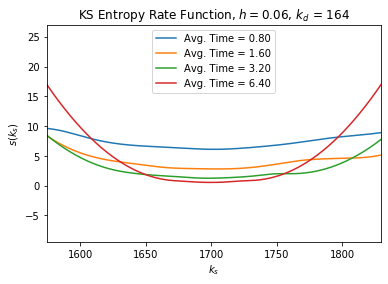

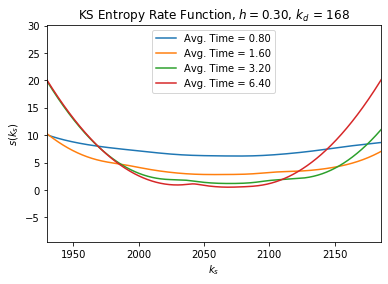

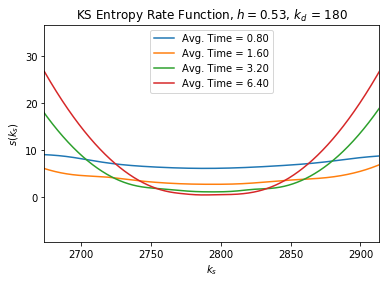

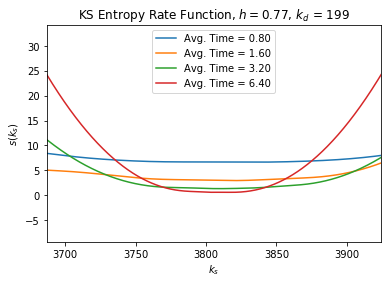

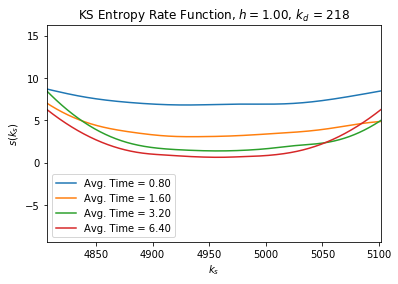

In [119]:
for i, data in enumerate(h_experiment):
    kd = data.k_d
    h = data.h
    tau = data.tau
    for L in [80, 160, 320, 640]:
        Ltau = L * tau
        ftle = ftcle_calculator(data.ftcle, L)
        ks = ks_entropy(data.ftcle, data.k_d)
        x_d = np.linspace(ks.min() - 100, ks.max() + 100, 1000) # Grid we evaluate PDF on
        kde = gaussian_kde(ks) # KDE. Using Gaussian kernels with default bandwidth, don't know how it decided bw?
        pdf = kde.evaluate(x_d)
        rate = - (np.log(pdf) / Ltau)
        plt.plot(x_d, rate, label = f'Avg. Time = {Ltau:.2f}')
    plt.title(f'KS Entropy Rate Function, $h = ${data.h:.2f}, $k_d$ = {kd}')
    plt.xlim(ks.min() - 100, ks.max() + 100)
    plt.xlabel(f'$k_s$')
    plt.ylabel(f'$s(k_s)$')
    plt.ylim(rate.min() - 10, rate.max() + 10)
    plt.legend()
    save = f'h-effect/{i + 1}/Rate-Functions_h{data.h:.2f}'.replace('.','_') + '/KS-Entropy-Rate.png'
    plt.savefig(save, dpi=1200)
    plt.show()